## Import libraries 

In [63]:
import sys
sys.path.append('../edaf')

In [ ]:
from Visualization.new_plot_helpers import *
from Visualization.new_data_helpers import *
import seaborn as sns
from Visualization.new_decomp import *
from sortedcontainers import SortedList, SortedDict
from loguru import logger
import os, sys, gzip, json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import JSON

from pathlib import Path
import ijson

%load_ext autoreload
%autoreload 2

sns.set_theme(style='darkgrid')  # Options include 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# Remove default handler
logger.remove()
# Add a new handler with level WARNING
logger.add(sys.stdout, level="ERROR")

9

## Intialize paths

In [66]:
MEAS_DIR = '../S1-meas/'
MEAS_LABEL = 's49'
DB_FILE = MEAS_DIR+MEAS_LABEL+'/'+'res_db.sql'
PLOTS_DIR = './plots/'+MEAS_LABEL+'/'
DATA_DIR = './data/'+MEAS_LABEL+'/'

## Analyzers 

In [67]:
IMPORT_FROM_JSON=True

In [68]:
MEAS_DIR = '../S1-meas/' ### change the paths here
MEAS_LABEL = 's49/jsons/'
DB_FILE = MEAS_DIR+MEAS_LABEL+'/'+'res_db.sql'
PLOTS_DIR = './plots/'+MEAS_LABEL+'/'
DATA_DIR = './data/'+MEAS_LABEL+'/'

IMPORT_FROM_JSON = True

if IMPORT_FROM_JSON==False:
    # packet analyzer
    analyzer = ULPacketAnalyzer(DB_FILE)
    uids_arr = range(analyzer.first_ueipid, analyzer.last_ueipid+1)
    packets = analyzer.figure_packettx_from_ueipids(uids_arr)
    packets_rnti_set = set([item['rlc.attempts'][0]['rnti'] for item in packets if item['rlc.attempts'][0]['rnti']!=None])
    print(f'RNTIs in packets: {list(packets_rnti_set)}')
    # sched analyzer
    sched_analyzer = ULSchedulingAnalyzer(
        total_prbs_num = 106, 
        symbols_per_slot = 14, 
        slots_per_frame = 20, 
        slots_duration_ms = 0.5, 
        scheduling_map_num_integers = 4,
        max_num_frames=100,
        db_addr = DB_FILE
    )
    
    begin_ts = sched_analyzer.first_ts
    end_ts = sched_analyzer.last_ts
    sched_arr = sched_analyzer.find_resource_schedules_from_ts(begin_ts, end_ts)
    sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
    bsrupd_arr = sched_analyzer.find_bsr_upd_from_ts(begin_ts, end_ts)
    sr_tx_arr = sched_analyzer.find_sr_tx_from_ts(begin_ts, end_ts)
    bsr_tx_arr = sched_analyzer.find_bsr_tx_from_ts(begin_ts, end_ts)
    sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr]+[bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])
    
    chan_analyzer = ULChannelAnalyzer(DB_FILE)
    begin_ts = chan_analyzer.first_ts
    end_ts = chan_analyzer.last_ts
    WINDOW_LEN_SECONDS = 2
    mcs_arr_all = chan_analyzer.find_mcs_from_ts(begin_ts,end_ts)
    tb_arr = chan_analyzer.find_mac_attempts_from_ts(begin_ts,end_ts)
    set_rnti = set([item['rnti'] for item in mcs_arr_all])
    # filter entries with rnti list(packets_rnti_set)[0] 
    if list(packets_rnti_set)[0]!=None:
        mcs_arr = [mcs for mcs in mcs_arr_all if mcs['rnti']==list(packets_rnti_set)[0]]
    mcs_sorted_dict = SortedDict({mcs['timestamp']: mcs for mcs in mcs_arr})

    #print(f'RNTIs in channel: {list(set_rnti)}')
else:
    packets = read_json(DATA_DIR+'packets.json')
    sr_tx_arr = read_json(DATA_DIR+'sr_tx.json')
    bsr_tx_arr = read_json(DATA_DIR+'bsr_tx.json')
    bsrupd_arr = read_json(DATA_DIR+'bsr_upd.json')
    bsrupd_sorted_dict = SortedDict({bsrupd['timestamp']: bsrupd for bsrupd in bsrupd_arr})
    sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr]+[bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])
    sched_arr = read_json(DATA_DIR+'sched.json')
    sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
    packets_rnti_set = set([item['rlc.attempts'][0]['rnti'] for item in packets if item['rlc.attempts'][0]['rnti']!=None])
    print(f'RNTIs in packets: {list(packets_rnti_set)}')
    mcs_arr_all = read_json(DATA_DIR+'mcs.json')
    tb_arr = read_json(DATA_DIR+'tb.json')
    set_rnti = set([item['rnti'] for item in mcs_arr_all])
    #filter entries with rnti list(packets_rnti_set)[0] 
    if list(packets_rnti_set)[0]!=None:
        mcs_arr = [mcs for mcs in mcs_arr_all if mcs['rnti']==list(packets_rnti_set)[0]]
    else:
        mcs_arr = mcs_arr_all
    mcs_sorted_dict = SortedDict({mcs['timestamp']: mcs for mcs in mcs_arr})

    #print(f'RNTIs in channel: {list(set_rnti)}')

RNTIs in packets: ['5fcf']


## Calculate delays

In [69]:
# send_ts = analyzer.nlmt_df['timestamps.client.send.wall'].to_numpy()
# send_ts = (send_ts)/1e6
# receive_ts = analyzer.nlmt_df['timestamps.server.receive.wall'].to_numpy()
# receive_ts = (receive_ts)/1e6
# idt = (send_ts[1:-1]-send_ts[0:-2])
# e2e_delays = receive_ts-send_ts

idt = np.array(list({packets[ind]['id']: packets[ind]['ip.in_t']-packets[ind-1]['ip.in_t'] for ind in range(1, len(packets)) if packets[ind]['ip.in_t']!=None and  packets[ind-1]['ip.in_t']!=None}.values()))
frame_alignment_delays = np.array(list({packet['id']: get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
scheduling_delays = np.array(list({packet['id']: get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
ran_delays = np.array(list({packet['id']: get_ran_delay(packet) for packet in packets if get_ran_delay(packet)!=None}.values()))
ran_delays_wo_frame_alignment_delay = np.array(list({packet['id']: get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
ran_delays_wo_scheduling_delay = np.array(list({packet['id']: get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
queueing_delays = np.array(list({packet['id']: get_queueing_delay(packet) for packet in packets if get_queueing_delay(packet)!=None}.values()))
queueing_delays_wo_scheduling_delay = np.array(list({packet['id']: get_queueing_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_queueing_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
segmentation_delay = np.array(list({packet['id']: get_segmentation_delay(packet) for packet in packets if get_segmentation_delay(packet)!=None}.values()))
segmentation_delays_wo_scheduling_delay = np.array(list({packet['id']: get_segmentation_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_segmentation_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
segments = np.array(list({packet['id']: get_segments(packet) for packet in packets if get_segments(packet)!=None}.values()))
retx_delays = np.array(list({packet['id']: get_retx_delay(packet) for packet in packets if get_retx_delay(packet)!=None}.values()))
mcss = np.array(list({packet['id']: get_mcs(packet, mcs_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_mcs(packet, mcs_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))

2024-11-06 15:34:33.880 | ERROR    | decomp:get_tx_delay:164 - Packet 39730 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.881 | ERROR    | decomp:get_tx_delay:164 - Packet 39730 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.882 | ERROR    | decomp:get_tx_delay:164 - Packet 39728 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.882 | ERROR    | decomp:get_tx_delay:164 - Packet 39728 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.911 | ERROR    | decomp:get_tx_delay:164 - Packet 38849 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.912 | ERROR    | decomp:get_tx_delay:164 - Packet 38849 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.918 | ERROR    | decomp:get_tx_delay:164 - Packet 38686 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.919 | ERROR    | decomp:get_tx_delay:164 - Packet 38686 phy.in_t or phy.in_t not present
2024-11-06 15:34:33.924 | ERROR    | decomp:get_tx_delay:164 - Packet 38523 phy.in_t or phy.in_t not present
2024-11-06 15:34:33

## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


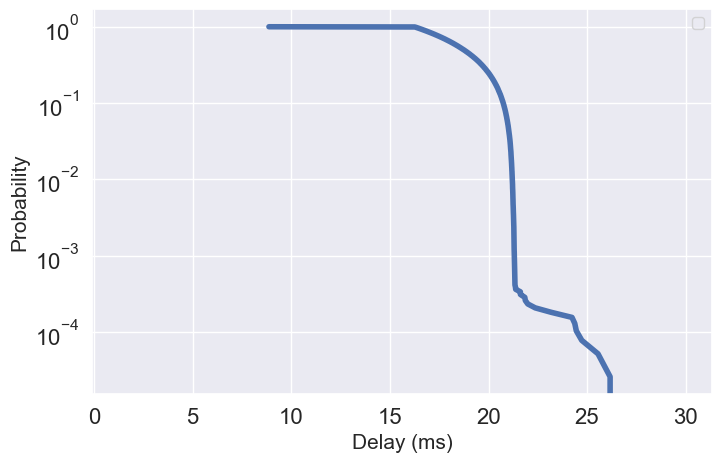

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


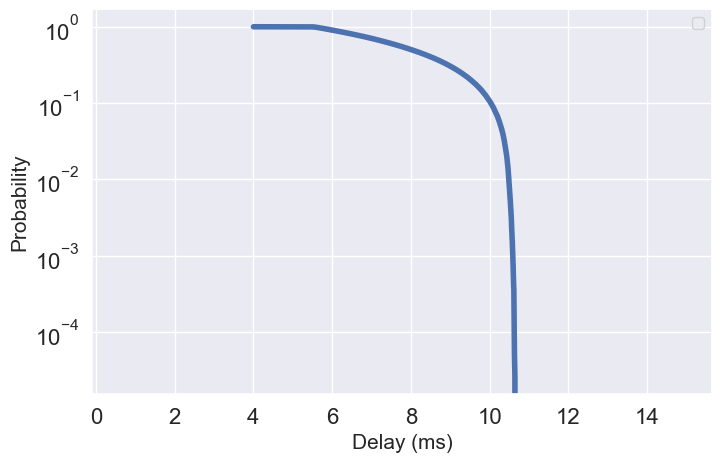

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


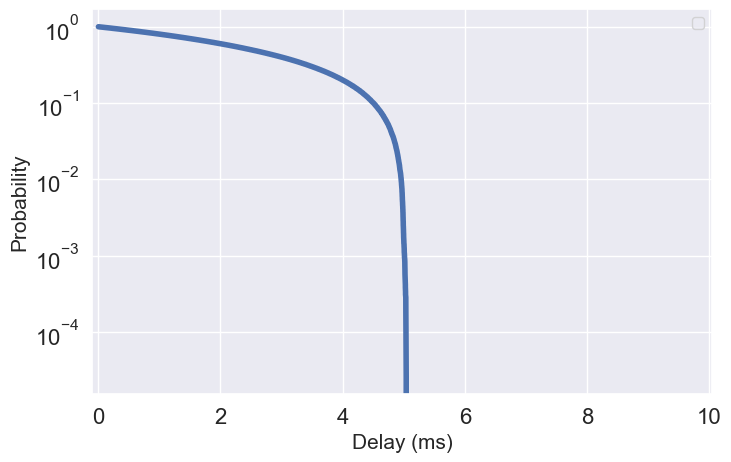

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


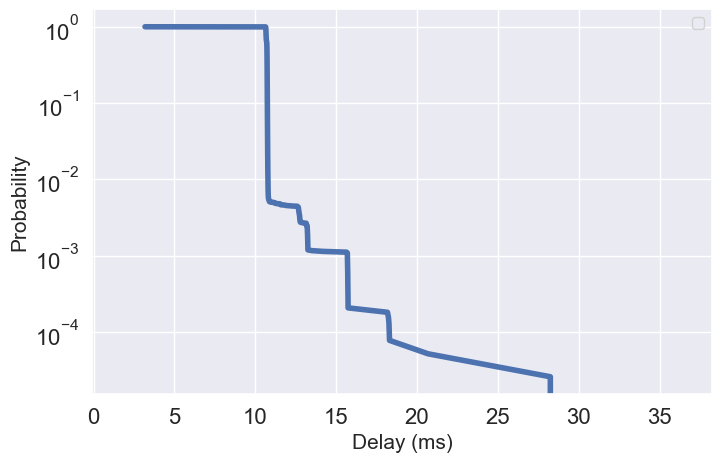

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


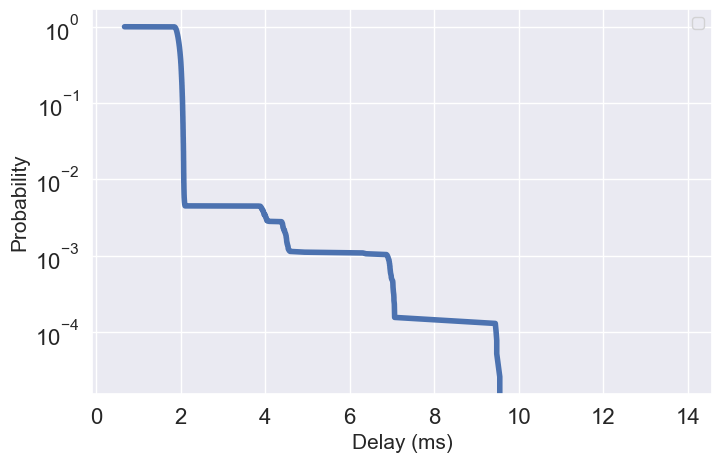

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


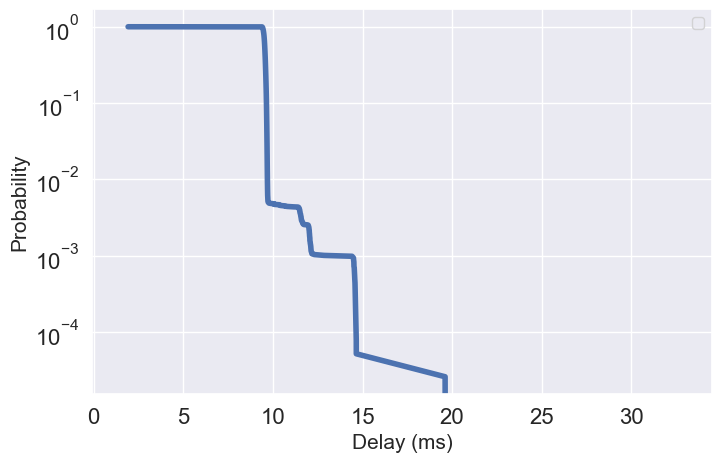

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


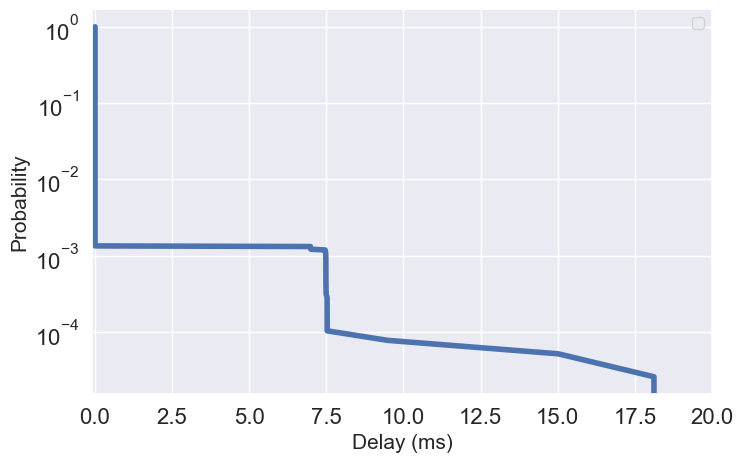

In [70]:
# Ensure the PLOTS_DIR exists
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
    
# skip first and last packets
SKIP_FIRST = 1000
SKIP_LAST = 100

# fig, ax  = plot_ccdf(e2e_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
# plt.savefig(f"{PLOTS_DIR}e2e_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
# plt.show()

# fig, ax  = plot_ccdf(idt[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
# plt.savefig(f"{PLOTS_DIR}idt_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
# plt.show()

fig, ax  = plot_ccdf(ran_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(scheduling_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}scheduling_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(frame_alignment_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}frame_alignment_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays_wo_scheduling_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(queueing_delays_wo_scheduling_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}queueing_delays_wo_scheduling_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(segmentation_delays_wo_scheduling_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}segmentation_delays_wo_scheduling_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(retx_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5), x_lim=20)
plt.savefig(f"{PLOTS_DIR}retx_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

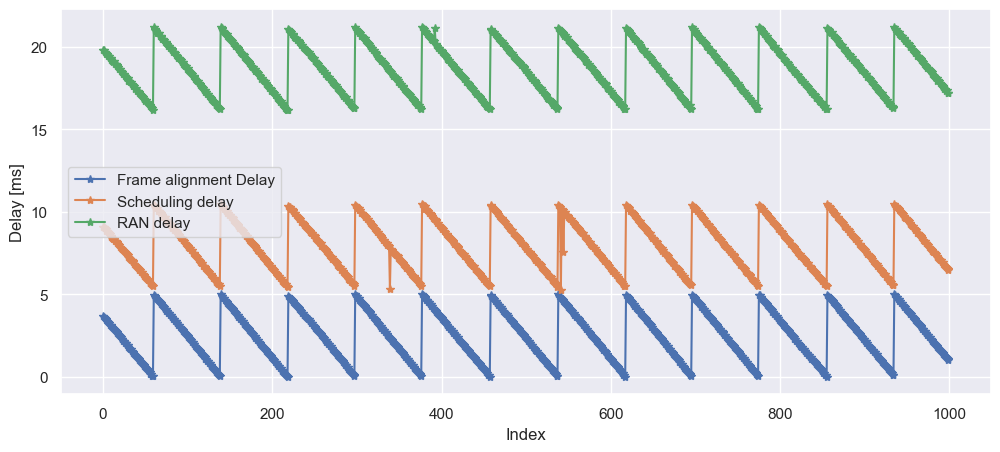

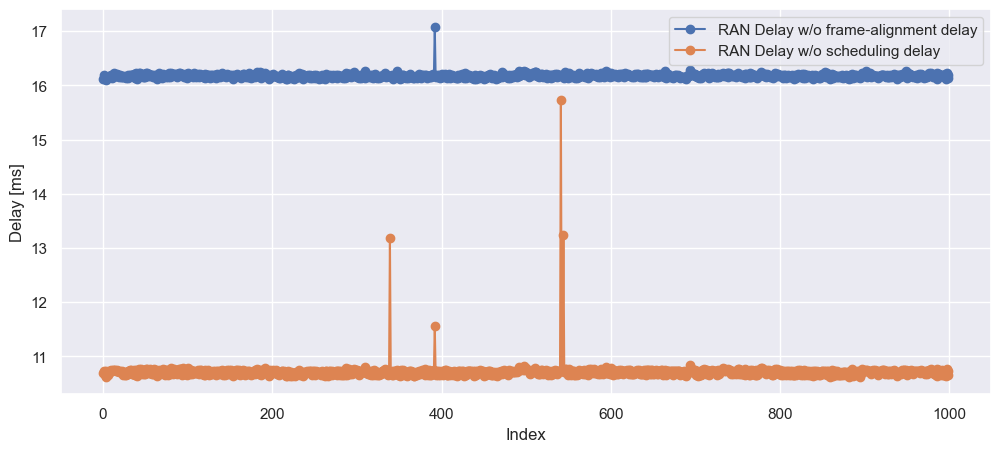

In [71]:
# plotting time series for frame alignment delay and scheduling delay
index_range = slice(5000, 6000)
SKIP_FIRST = 1000
SKIP_LAST = 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12,5))

# Plotting each data set with different markers
ax.plot(frame_alignment_delays[index_range], marker='*', label='Frame alignment Delay')
ax.plot(scheduling_delays[index_range], marker='*', label='Scheduling delay')
ax.plot(ran_delays[index_range], marker='*', label='RAN delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_timeseries.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## ran delay without frame alignment delay and scheduling
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12,5))

# Plotting each data set with different markers
ax.plot(ran_delays[index_range]-frame_alignment_delays[index_range], marker='o', label='RAN Delay w/o frame-alignment delay')
ax.plot(ran_delays[index_range]-scheduling_delays[index_range], marker='o', label='RAN Delay w/o scheduling delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_wo_scheduling_timeseries.png", dpi=300, bbox_inches='tight')

In [72]:
# index_range = range(5002, 5005)

# fig, ax = plt.subplots()

# uids_arr = index_range

# begin_ts,end_ts = plot_packet_tree_from_ueipids(uids_arr, analyzer.ue_ip_packets_df, analyzer.ue_iprlc_rel_df, analyzer.ue_rlc_segments_df, analyzer.ue_mac_attempts_df, analyzer.gnb_ip_packets_df, analyzer.gnb_iprlc_rel_df, analyzer.gnb_rlc_segments_df, analyzer.gnb_mac_attempts_df, ax, False)


# # Now plot Rerouce blocks on top
# plot_resourcegrid(begin_ts, end_ts, sched_analyzer.gnb_sched_maps_df, ax)

# plot_sched_tree(begin_ts, end_ts, sched_analyzer.ue_srtxs_df, sched_analyzer.ue_bsrupds_df, sched_analyzer.ue_bsrtxs_df, sched_analyzer.ue_uldcis_df, sched_analyzer.gnb_sched_reports_df, ax)

# # Set title, labels, and grid
# ax.set_xlabel('Time [ms]')  # Corrected: ax.set_xlabel()
# ax.set_ylabel('Scheduling Process')  # Corrected: ax.set_ylabel()
# ax.set_ylim([0,6])
# ax.set_xlim([0,(end_ts - begin_ts)*1000])
# ax.xaxis.grid(True)
# fig.set_figheight(5)
# fig.set_figwidth(9)
# fig.savefig(f"{PLOTS_DIR}res1.png")

# fig, ax = plt.subplots()

# begin_ts,end_ts = plot_packet_tree_from_ueipids(uids_arr, sched_analyzer.ue_ip_packets_df, sched_analyzer.ue_iprlc_rel_df, sched_analyzer.ue_rlc_segments_df, sched_analyzer.ue_mac_attempts_df, sched_analyzer.gnb_ip_packets_df, sched_analyzer.gnb_iprlc_rel_df, sched_analyzer.gnb_rlc_segments_df, sched_analyzer.gnb_mac_attempts_df, ax, True)

# plot_resourcegrid(begin_ts, end_ts, sched_analyzer.gnb_sched_maps_df, ax)

# # Set title, labels, and grid
# ax.set_xlabel('Time [ms]')  # Corrected: ax.set_xlabel()
# ax.set_ylabel('Packet Transmission Process')  # Corrected: ax.set_ylabel()
# ax.set_ylim([0,6])
# ax.set_xlim([0,(end_ts - begin_ts)*1000])
# ax.xaxis.grid(True)
# fig.set_figheight(5)
# fig.set_figwidth(9)
# fig.savefig(f"{PLOTS_DIR}res2.png")

# Code for multiple plots

## Intialize paths


In [73]:
### combine plots
MEAS_DIR = '../S1-meas/'
MEAS_LABELS = ['s49/jsons/','s39/','s40']#, 's57']
LABELS = ['Conf1']#, 'Conf2']
DB_FILES = [ MEAS_DIR+MEAS_LABEL+'/'+'res_db.sql' for MEAS_LABEL in MEAS_LABELS]  # Add more DB files as needed

In [74]:
IMPORT_FROM_JSON=True

## load multiple DB files and extract delays

In [75]:
# Initialize lists or dictionaries to store results from each file
packets_list = []
sched_sorted_dicts = []
bsrupd_sorted_dicts = []
sr_bsr_tx_sorted_lists = []
mcs_data = []
mcs_dicts = []
tb_data = []
delays_data = []  # New list to store delays for each file

# Loop through each label and perform the analysis
for MEAS_LABEL in MEAS_LABELS:
    if IMPORT_FROM_JSON == False:
        FILE_PATH = MEAS_DIR + MEAS_LABEL + '/' + 'res_db.sql'
        print(f'reading trace: {FILE_PATH}')
        
        # Packet analyzer
        analyzer = ULPacketAnalyzer(FILE_PATH)
        uids_arr = range(analyzer.first_ueipid, analyzer.last_ueipid + 1)
        packets = analyzer.figure_packettx_from_ueipids(uids_arr)
        packets_rnti_set = set([item['rlc.attempts'][0]['rnti'] for item in packets if item['rlc.attempts'][0]['rnti']!=None])
        print(f'RNTIs in packets: {list(packets_rnti_set)}')
        packets_list.append(packets)
        
        # Scheduling analyzer
        sched_analyzer = ULSchedulingAnalyzer(
            total_prbs_num=106,
            symbols_per_slot=14,
            slots_per_frame=20,
            slots_duration_ms=0.5,
            scheduling_map_num_integers=4,
            max_num_frames=100,
            db_addr=FILE_PATH
        )
        
        begin_ts = sched_analyzer.first_ts
        end_ts = sched_analyzer.last_ts
        sched_arr = sched_analyzer.find_resource_schedules_from_ts(begin_ts, end_ts)
        sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
        sched_sorted_dicts.append(sched_sorted_dict)
        
        bsrupd_arr = sched_analyzer.find_bsr_upd_from_ts(begin_ts, end_ts)
        bsrupd_sorted_dict = SortedDict({bsrupd['timestamp']: bsrupd for bsrupd in bsrupd_arr})
        bsrupd_sorted_dicts.append(bsrupd_sorted_dict)
        sr_tx_arr = sched_analyzer.find_sr_tx_from_ts(begin_ts, end_ts)
        bsr_tx_arr = sched_analyzer.find_bsr_tx_from_ts(begin_ts, end_ts)
        sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr] + [bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])
        sr_bsr_tx_sorted_lists.append(sr_bsr_tx_sorted_list)

        # Channel analyzer
        chan_analyzer = ULChannelAnalyzer(FILE_PATH)
        begin_ts = chan_analyzer.first_ts
        end_ts = chan_analyzer.last_ts
        WINDOW_LEN_SECONDS = 2
        mcs_arr_all = chan_analyzer.find_mcs_from_ts(begin_ts, end_ts)
        set_rnti = set([item['rnti'] for item in mcs_arr_all])
        #print(f'RNTIs in channel: {list(set_rnti)}')
        # filter entries with rnti list(packets_rnti_set)[0] 
        if list(packets_rnti_set)[0]!=None:
            mcs_arr = [mcs for mcs in mcs_arr_all if mcs['rnti']==list(packets_rnti_set)[0]]    
        else:
            mcs_arr = mcs_arr_all
        mcs_dict = SortedDict({mcs['timestamp']: mcs for mcs in mcs_arr})
        mcs_dicts.append(mcs_dict)
        tb_arr = chan_analyzer.find_mac_attempts_from_ts(begin_ts, end_ts)
        mcs_data.append(mcs_arr)
        tb_data.append(tb_arr)
    else:
        DATA_DIR = './data/' + MEAS_LABEL + '/'
        print(f'reading from json in {DATA_DIR}')
        packets = read_json(DATA_DIR+'packets.json')
        packets_list.append(packets)
        packets_rnti_set = set([item['rlc.attempts'][0]['rnti'] for item in packets if item['rlc.attempts'][0]['rnti']!=None])
        print(f'RNTIs in packets: {list(packets_rnti_set)}')
                        
        sr_tx_arr = read_json(DATA_DIR+'sr_tx.json')
        bsr_tx_arr = read_json(DATA_DIR+'bsr_tx.json')
        bsrupd_arr = read_json(DATA_DIR+'bsr_upd.json')
        bsrupd_sorted_dict = SortedDict({bsrupd['timestamp']: bsrupd for bsrupd in bsrupd_arr})
        bsrupd_sorted_dicts.append(bsrupd_sorted_dict)

        bsrupd_sorted_dict = SortedDict({bsrupd['timestamp']: bsrupd for bsrupd in bsrupd_arr})
        sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr]+[bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])
        sr_bsr_tx_sorted_lists.append(sr_bsr_tx_sorted_list)

        sched_arr = read_json(DATA_DIR+'sched.json')
        sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
        sched_sorted_dicts.append(sched_sorted_dict)
        mcs_arr_all = read_json(DATA_DIR+'mcs.json')
        set_rnti = set([item['rnti'] for item in mcs_arr_all])
        #print(f'RNTIs in channel: {list(set_rnti)}')
        if list(packets_rnti_set)[0]!=None:
            mcs_arr = [mcs for mcs in mcs_arr_all if mcs['rnti']==list(packets_rnti_set)[0]]    
        else:
            mcs_arr = mcs_arr_all
        tb_arr = read_json(DATA_DIR+'tb.json')
        mcs_data.append(mcs_arr)
        mcs_dict = SortedDict({mcs['timestamp']: mcs for mcs in mcs_arr})
        mcs_dicts.append(mcs_dict)
        tb_data.append(tb_arr)
    
    # Delays Calculation
    # send_ts = analyzer.nlmt_df['timestamps.client.send.wall'].to_numpy() / 1e6
    # receive_ts = analyzer.nlmt_df['timestamps.server.receive.wall'].to_numpy() / 1e6
    # idt = send_ts[1:-1] - send_ts[0:-2]
    # e2e_delays = receive_ts - send_ts
    
    # Frame alignment delays
    frame_alignment_delays = np.array(list({packet['id']: get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) 
                                            for packet in packets 
                                            if get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Scheduling delays
    scheduling_delays = np.array(list({packet['id']: get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
                                       for packet in packets 
                                       if get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # RAN delays
    ran_delays = np.array(list({packet['id']: get_ran_delay(packet) 
                                for packet in packets 
                                if get_ran_delay(packet) is not None}.values()))
    
    # RAN delays without frame alignment
    ran_delays_wo_frame_alignment_delay = np.array(list({packet['id']: get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) 
                                                         for packet in packets 
                                                         if get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # RAN delays without scheduling delay
    ran_delays_wo_scheduling_delay = np.array(list({packet['id']: get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
                                                    for packet in packets 
                                                    if get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Queueing delays
    queueing_delays = np.array(list({packet['id']: get_queueing_delay(packet) 
                                     for packet in packets 
                                     if get_queueing_delay(packet) is not None}.values()))

    # Queueing delays without scheduling
    queueing_delays_wo_scheduling_delay = np.array(list({packet['id']: get_queueing_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
                                     for packet in packets 
                                     if get_queueing_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Retransmission delays
    retx_delays = np.array(list({packet['id']: get_retx_delay(packet) 
                                 for packet in packets 
                                 if get_retx_delay(packet) is not None}.values()))
    
    # Segmentation delays
    segmentation_delays = np.array(list({packet['id']: get_segmentation_delay(packet) 
                                 for packet in packets 
                                 if get_segmentation_delay(packet) is not None}.values()))

    # segmentation delays without scheduling delay
    segmentation_delays_wo_scheduling_delay = np.array(list({packet['id']: get_segmentation_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
                                 for packet in packets 
                                 if get_segmentation_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))    

    # segments
    segments = np.array(list({packet['id']: get_segments(packet) for packet in packets if get_segments(packet) is not None}.values()))
    

    # mcs 
    mcs = np.array(list({packet['id']: get_mcs(packet, mcs_dict) for packet in packets if get_mcs(packet, mcs_dict) is not None}.values()))
    
    # Collect all delays in a dictionary for this file
    delays_data.append({
        #'e2e_delays': e2e_delays,
        'frame_alignment_delays': frame_alignment_delays,
        'scheduling_delays': scheduling_delays,
        'ran_delays': ran_delays,
        'ran_delays_wo_frame_alignment_delay': ran_delays_wo_frame_alignment_delay,
        'ran_delays_wo_scheduling_delay': ran_delays_wo_scheduling_delay,
        'queueing_delays': queueing_delays,
        'queueing_delays_wo_scheduling_delay': queueing_delays_wo_scheduling_delay,
        'segmentation_delays': segmentation_delays,
        'segmentation_delays_wo_scheduling_delay': segmentation_delays_wo_scheduling_delay,
        'retx_delays': retx_delays,
        'segments': segments,
        'mcs': mcs,
    })

# Now you have the data from all files stored in packets_list, sched_sorted_dicts, sr_bsr_tx_sorted_lists, mcs_data, tb_data, and delays_data

reading from json in ./data/s49/jsons//
RNTIs in packets: ['5fcf']
2024-11-06 15:34:58.014 | ERROR    | decomp:get_tx_delay:164 - Packet 39730 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.015 | ERROR    | decomp:get_tx_delay:164 - Packet 39730 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.016 | ERROR    | decomp:get_tx_delay:164 - Packet 39728 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.017 | ERROR    | decomp:get_tx_delay:164 - Packet 39728 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.045 | ERROR    | decomp:get_tx_delay:164 - Packet 38849 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.046 | ERROR    | decomp:get_tx_delay:164 - Packet 38849 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.054 | ERROR    | decomp:get_tx_delay:164 - Packet 38686 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.054 | ERROR    | decomp:get_tx_delay:164 - Packet 38686 phy.in_t or phy.in_t not present
2024-11-06 15:34:58.060 | ERROR    | decomp:get_tx_delay:164 

KeyError: 'rnti'

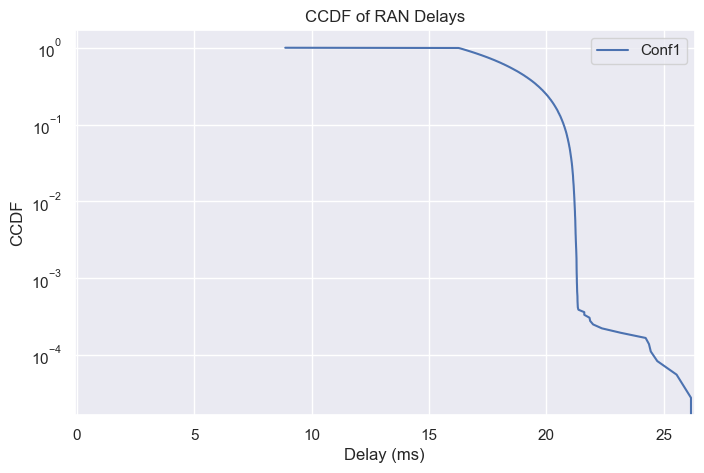

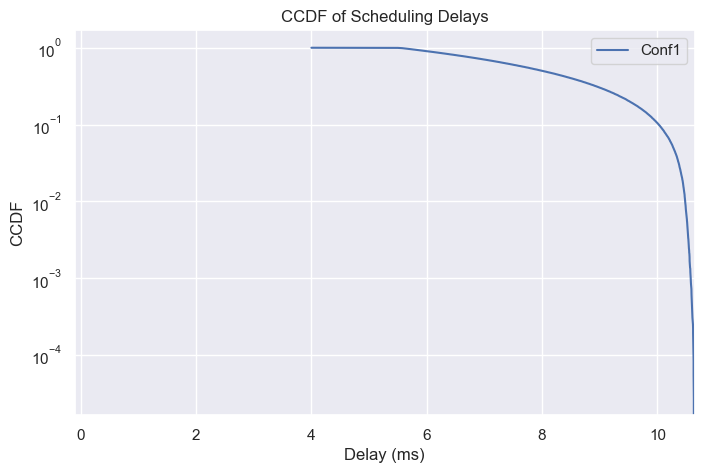

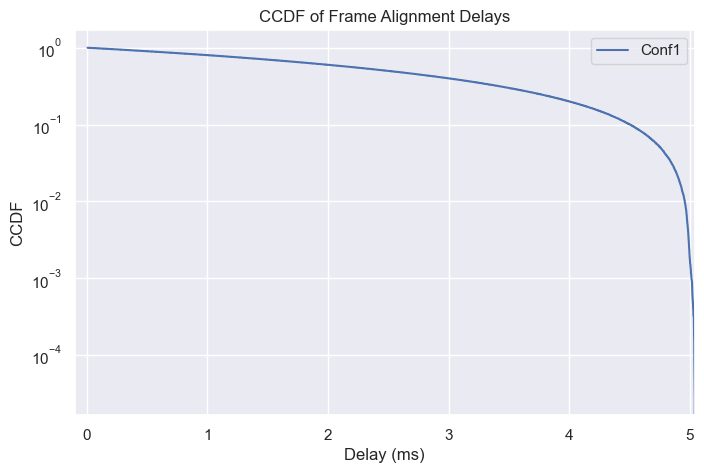

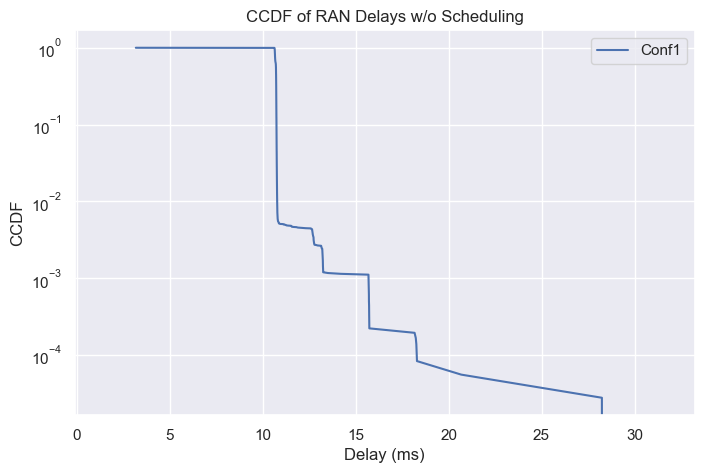

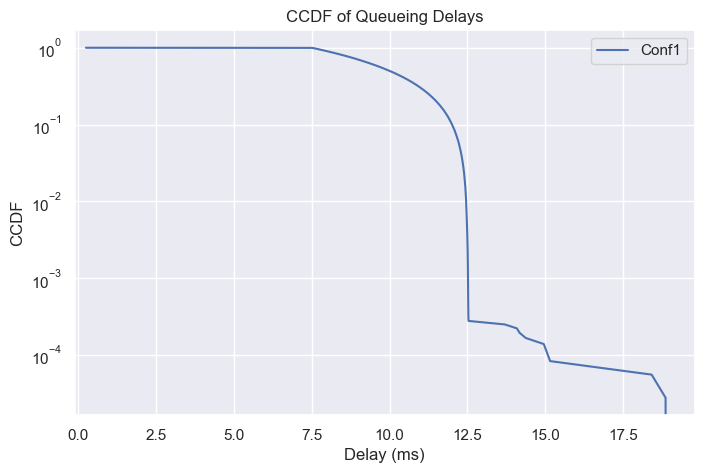

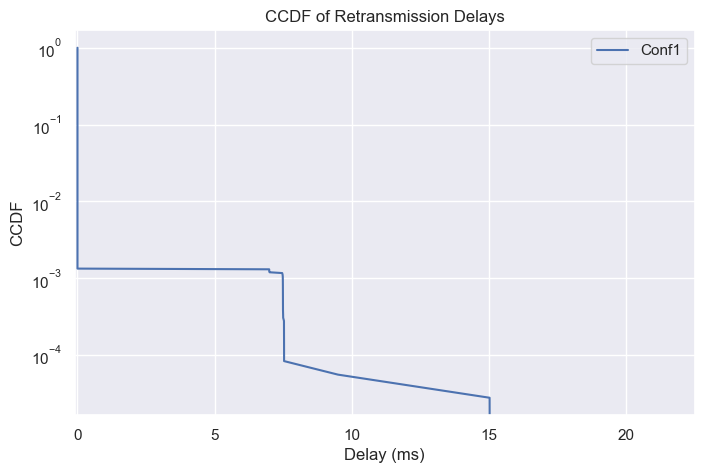

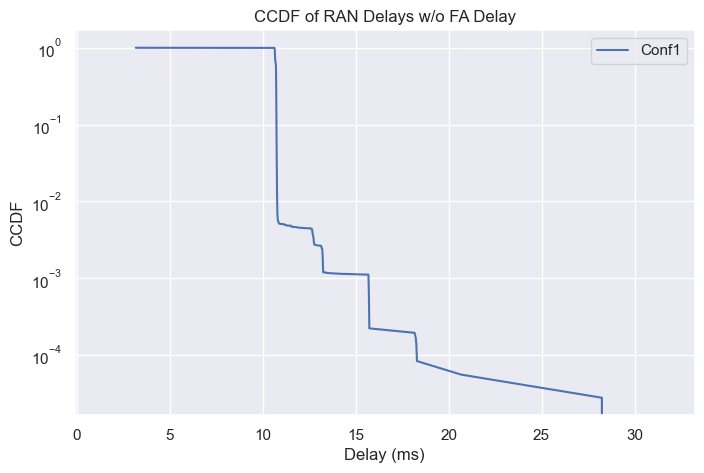

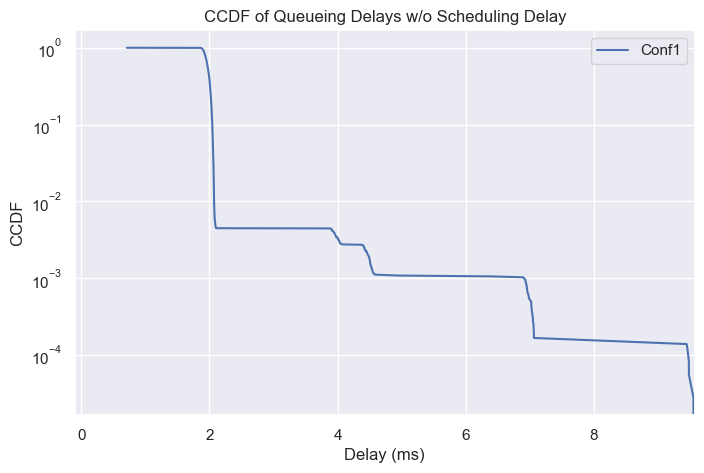

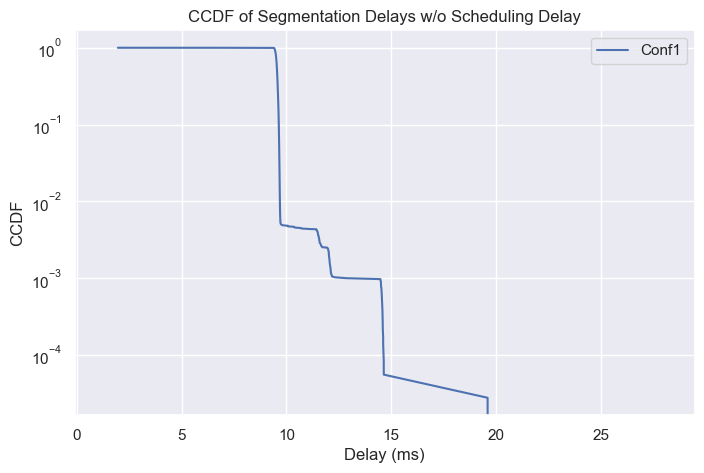

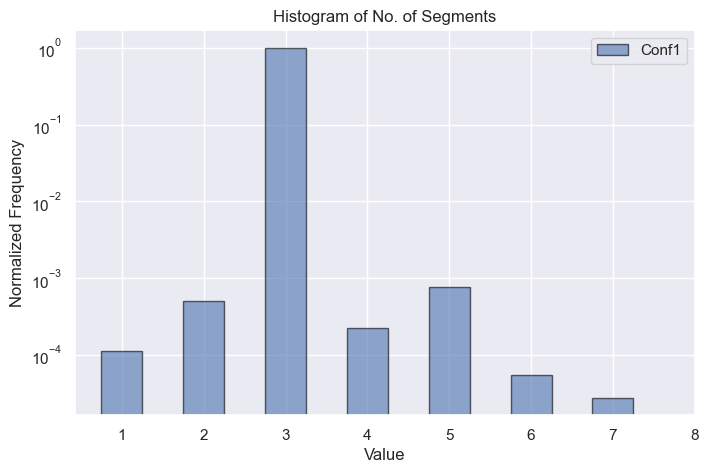

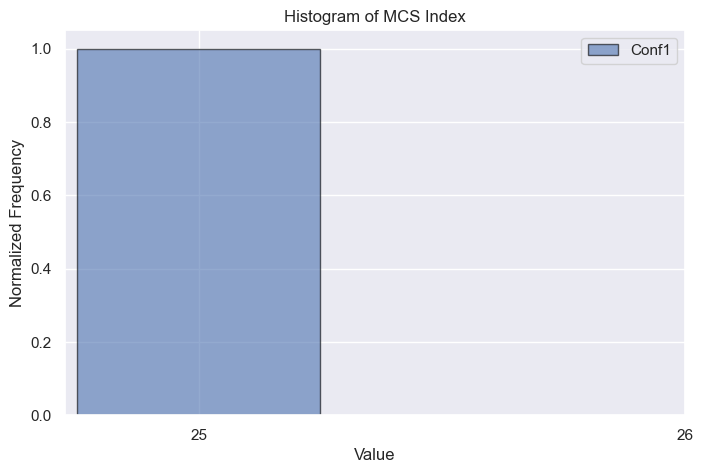

In [ ]:
# Ensure the PLOTS_DIR exists
PLOTS_DIR = "./plots/combined_"+"_".join(MEAS_LABELS)+"/"
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

# Skip constants
SKIP_FIRST = 1000
SKIP_LAST = 3000

# Initialize lists to store delay data from all DB files for each delay type
e2e_delays_per_meas = []
ran_delays_per_meas = []
scheduling_delays_per_meas = []
frame_alignment_delays_per_meas = []
ran_delays_wo_frame_alignment_delay_per_meas = []
ran_delays_wo_scheduling_delay_per_meas = []
queueing_delays_per_meas = []
queueing_delays_wo_scheduling_delay_per_meas = []
retx_delays_per_meas = []
segmentation_delays_per_meas = []
segmentation_delays_wo_scheduling_delay_per_meas = []
mcs_per_meas = []
segments_per_meas = []


# Collect delay data from each DB file
for idx, delays in enumerate(delays_data):
    #e2e_delays_per_meas.append(delays['e2e_delays'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_per_meas.append(delays['ran_delays'][SKIP_FIRST:-SKIP_LAST])
    scheduling_delays_per_meas.append(delays['scheduling_delays'][SKIP_FIRST:-SKIP_LAST])
    frame_alignment_delays_per_meas.append(delays['frame_alignment_delays'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_wo_frame_alignment_delay_per_meas.append(delays['ran_delays_wo_frame_alignment_delay'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_wo_scheduling_delay_per_meas.append(delays['ran_delays_wo_scheduling_delay'][SKIP_FIRST:-SKIP_LAST])
    queueing_delays_per_meas.append(delays['queueing_delays'][SKIP_FIRST:-SKIP_LAST])
    queueing_delays_wo_scheduling_delay_per_meas.append(delays['queueing_delays_wo_scheduling_delay'][SKIP_FIRST:-SKIP_LAST])
    retx_delays_per_meas.append(delays['retx_delays'][SKIP_FIRST:-SKIP_LAST])
    segmentation_delays_per_meas.append(delays['segmentation_delays'][SKIP_FIRST:-SKIP_LAST])
    segmentation_delays_wo_scheduling_delay_per_meas.append(delays['segmentation_delays_wo_scheduling_delay'][SKIP_FIRST:-SKIP_LAST])
    mcs_per_meas.append(delays['mcs'][SKIP_FIRST:-SKIP_LAST])
    segments_per_meas.append(delays['segments'][SKIP_FIRST:-SKIP_LAST])

# Plot RAN Delays for all measurement files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_per_meas, ax, delay_type_label='RAN Delays', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Scheduling Delays for all measurement files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(scheduling_delays_per_meas, ax, delay_type_label='Scheduling Delays', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}scheduling_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Frame Alignment Delays for all measurement files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(frame_alignment_delays_per_meas, ax, delay_type_label='Frame Alignment Delays', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}frame_alignment_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot RAN Delays w/o Scheduling for all measurement files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_wo_scheduling_delay_per_meas, ax, delay_type_label='RAN Delays w/o Scheduling', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_scheduling_delay_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Queueing Delays for all measurement files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(queueing_delays_per_meas, ax, delay_type_label='Queueing Delays', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}queueing_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Retransmission Delays for all measurement files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(retx_delays_per_meas, ax, delay_type_label='Retransmission Delays', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}retx_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_wo_scheduling_delay_per_meas, ax, delay_type_label='RAN Delays w/o FA Delay', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(queueing_delays_wo_scheduling_delay_per_meas, ax, delay_type_label='Queueing Delays w/o Scheduling Delay', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}queueing_delays_wo_scheduling_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(segmentation_delays_wo_scheduling_delay_per_meas, ax, delay_type_label='Segmentation Delays w/o Scheduling Delay', labels=LABELS)
plt.savefig(f"{PLOTS_DIR}segmentation_delays_wo_scheduling_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

# Plot Segments Histograms
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_histograms(segments_per_meas, ax, delay_type_label='No. of Segments', labels=LABELS, y_log=True, outlier=None)
plt.savefig(f"{PLOTS_DIR}segments_hist_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot MCS Histograms
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_histograms(mcs_per_meas, ax, delay_type_label='MCS Index', labels=LABELS, y_log=False, outlier=None)
plt.savefig(f"{PLOTS_DIR}mcs_hist_plot.png", dpi=300, bbox_inches='tight')
plt.show()


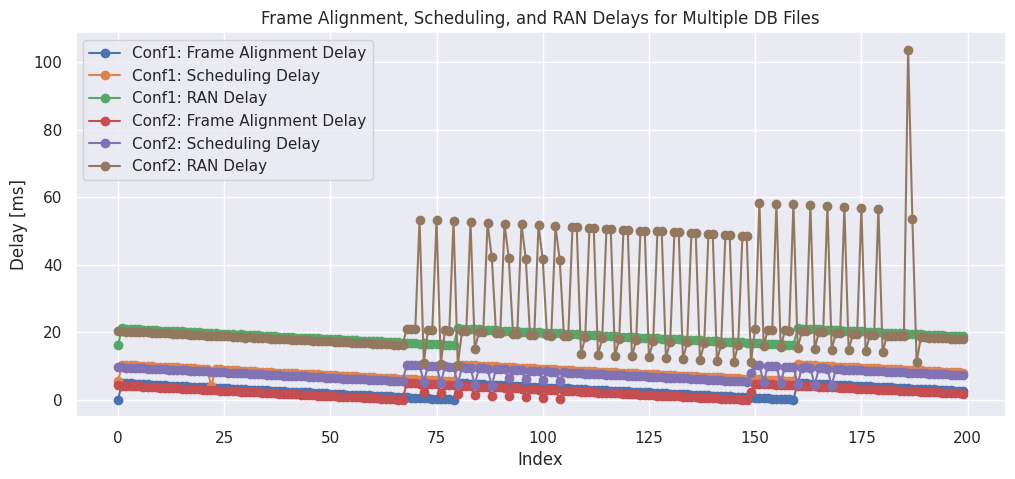

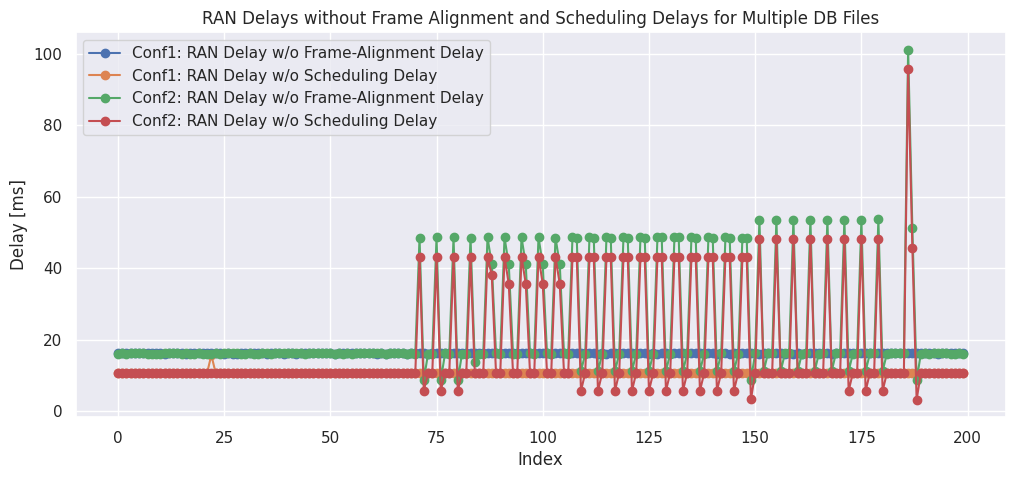

In [ ]:
# Index range and skip constants
index_range = slice(2500, 2700)
SKIP_FIRST = 1000
SKIP_LAST = 100

# Create a figure and axes for frame alignment, scheduling, and RAN delays
fig, ax = plt.subplots(figsize=(12, 5))

# Plot delays for all DB files on the same axis
for idx, delays in enumerate(delays_data):
    # Extract delays for the current DB_FILE
    frame_alignment_delays = delays['frame_alignment_delays']
    scheduling_delays = delays['scheduling_delays']
    ran_delays = delays['ran_delays']
    
    # Plotting each data set with different markers and labels for each DB file
    ax.plot(frame_alignment_delays[index_range], marker='o', label=f'{LABELS[idx]}: Frame Alignment Delay')
    ax.plot(scheduling_delays[index_range], marker='o', label=f'{LABELS[idx]}: Scheduling Delay')
    ax.plot(ran_delays[index_range], marker='o', label=f'{LABELS[idx]}: RAN Delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')
ax.set_title('Frame Alignment, Scheduling, and RAN Delays for Multiple DB Files')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_timeseries_combined.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Create a figure and axes for RAN delay without frame alignment delay and scheduling delay
fig, ax = plt.subplots(figsize=(12, 5))

# Plot RAN delay without frame alignment and scheduling delays for all DB files on the same axis
for idx, delays in enumerate(delays_data):
    # Extract delays for the current DB_FILE
    frame_alignment_delays = delays['frame_alignment_delays']
    scheduling_delays = delays['scheduling_delays']
    ran_delays = delays['ran_delays']

    # Plotting each data set with different markers and labels for each DB file
    ax.plot(ran_delays[index_range] - frame_alignment_delays[index_range], marker='o', label=f'{LABELS[idx]}: RAN Delay w/o Frame-Alignment Delay')
    ax.plot(ran_delays[index_range] - scheduling_delays[index_range], marker='o', label=f'{LABELS[idx]}: RAN Delay w/o Scheduling Delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')
ax.set_title('RAN Delays without Frame Alignment and Scheduling Delays for Multiple DB Files')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_wo_scheduling_timeseries_combined.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
JSON(packet)